<a href="https://colab.research.google.com/github/Lisa-creates/Time-series-analysis/blob/main/ARIMA_%D0%B8%D0%BD%D0%B4%D0%B5%D0%BA%D1%81_%D1%86%D0%B5%D0%BD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

import pandas as pd
import matplotlib as plt
import numpy as np
from datetime import datetime, timedelta
from collections import OrderedDict
import matplotlib.pyplot as plt

import warnings
import itertools
import statsmodels.api as sm

!pip install pmdarima

import pmdarima as pm


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 18.6 MB/s eta 0:00:00


In [ ]:
def is_stationarity(df) -> int:
  res = adfuller(df.values)
#  t_stat, p_value_KPSS, _, critical_values = kpss(df, regression='c')
  print('Ряд стационарен?',  res[1] < 0.05, res[1]) #or p_value_KPSS > 0.05)
  df_diff = df
  d = 0
  df_diff = df_diff.diff(periods = 12).dropna()
  while res[1] > 0.05: #or p_value_KPSS < 0.05:
    df_diff = df_diff.diff(periods = 1).dropna()
    res = adfuller(df_diff.values)
 #   t_stat, p_value_KPSS, _, critical_values = kpss(df, regression='c')
    d += 1
    print('Augmented Dickey-Fuller Statistic: ', res[0])
    print('p-value:', res[1])
 # print('p-value KPSS:', p_value_KPSS)
  #
  # df_diff = df_diff - df_diff.shift(12)
  # df_diff = df_diff.dropna()
  ax = df_diff.plot(figsize = (12,6), legend = None)
  ax.set(xlabel = 'Date', ylabel = 'Price')

  acf_diff = plot_acf(df_diff)
  pacf_diff = plot_pacf(df_diff)

  return d


def print_metric(df_test, forecast_test):
  print('mae ARIMA: ', mean_absolute_error(df_test, forecast_test))
  print('mape ARIMA: ', mean_absolute_percentage_error(np.array(df_test['Цены']), np.array(forecast_test)))
  print('rmse ARIMA: ', np.sqrt(mean_squared_error(df_test['Цены'], forecast_test)))
  print('mse ARIMA:: ', mean_squared_error(df_test['Цены'], forecast_test))


def arr_date(date1, date2) -> list:
  y0 = int( date1.split('-')[0] )
  y1 = int( date2.split('-')[0] )
  m0 = int( date1.split('-')[1] ) - 1
  m1 = int( date2.split('-')[1] ) - 1

  dat = []
  start = m0
  for y in range(y0, y1+1):
      for m in range(start,12):
        if m % 12 + 1 < 10:
          dat.append('0' + str(m  % 12 + 1)+'-'+str(y) )
        else:
          dat.append(str(m % 12 + 1)+'-'+str(y) )

        if y == y1 and (m % 12) == m1:
              break
      start = 0

  return dat


In [ ]:
df_orig = pd.read_excel('data (4).xls')

n = 4
df = df_orig.iloc[n]
df = pd.DataFrame(df)
df = df[2:]
df = df.rename(columns={n: 'Цены'})

dat = arr_date("2003-01-01", "2023-04-07")

dat = pd.to_datetime(dat, format='%m-%Y')
# print(dat)
df['Date'] = dat
df = df.set_index('Date')
print(df.head())

              Цены
Date              
2003-01-01   102.4
2003-02-01  101.63
2003-03-01  101.05
2003-04-01  101.02
2003-05-01   100.8


/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


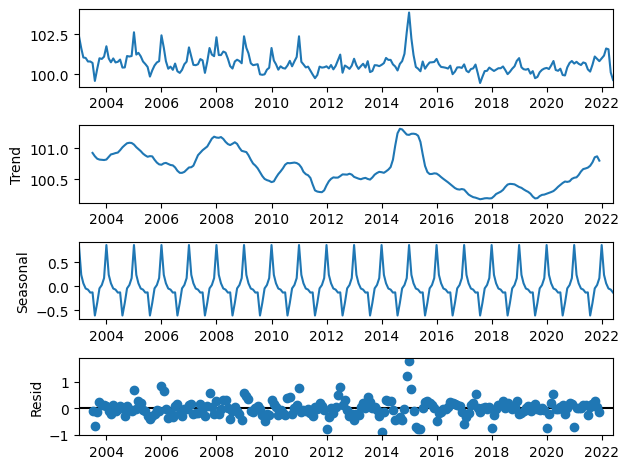

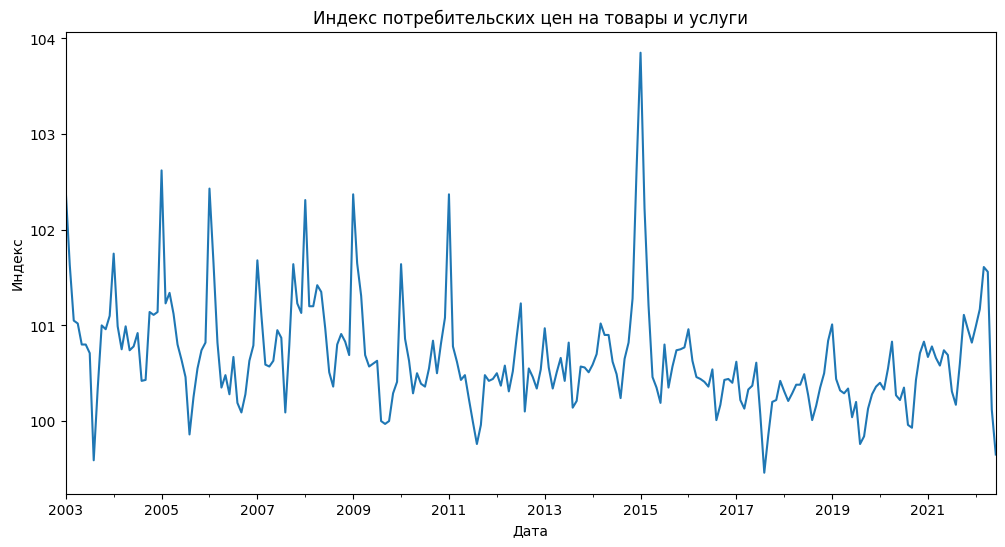

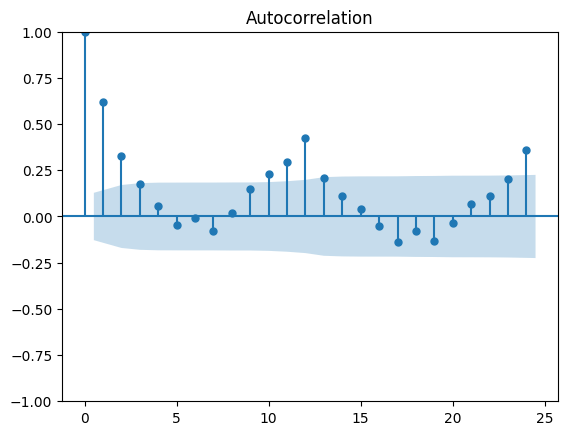

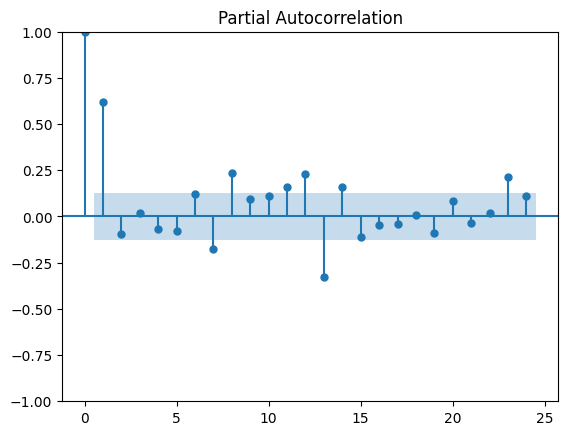

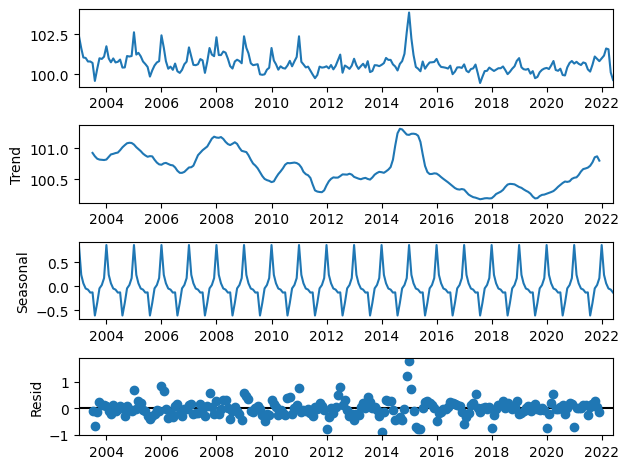

In [ ]:
r = df.shape[0] - 10 # кол-во строк минус 10 (10 - тестовой выборки)

df_test = df[r:]
df = df[:r]
df['Цены'] = df['Цены'].astype(float)

# df.plot()
ax = df.plot(figsize = (12,6), legend = None)
ax.set(title = 'Индекс потребительских цен на товары и услуги', xlabel = 'Дата', ylabel = 'Индекс')

acf_df = plot_acf(df.values)
pacf_df = plot_pacf(df.values)
sd = seasonal_decompose(df)
sd.plot()

Ряд стационарен? False 0.09456367724652698
Augmented Dickey-Fuller Statistic:  -6.552372763197856
p-value: 8.785781604400636e-09
1


/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


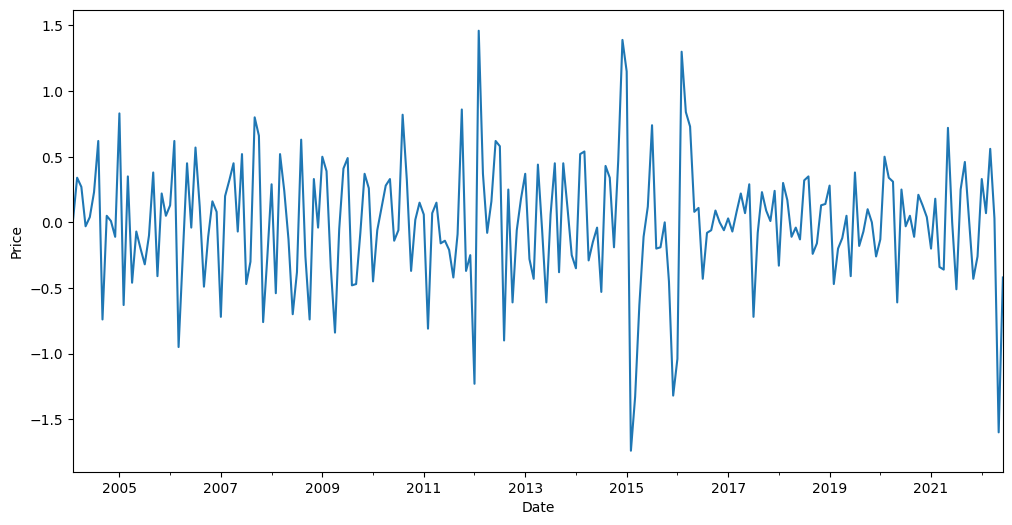

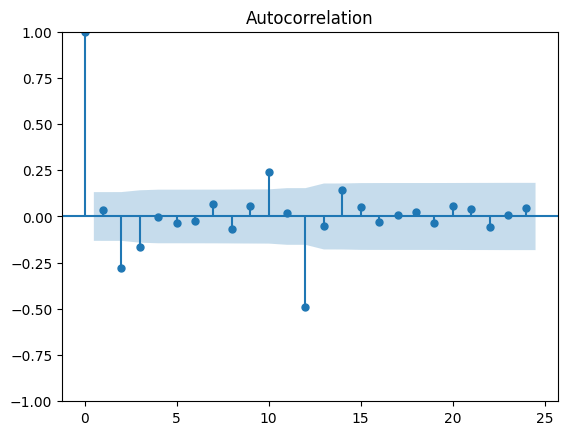

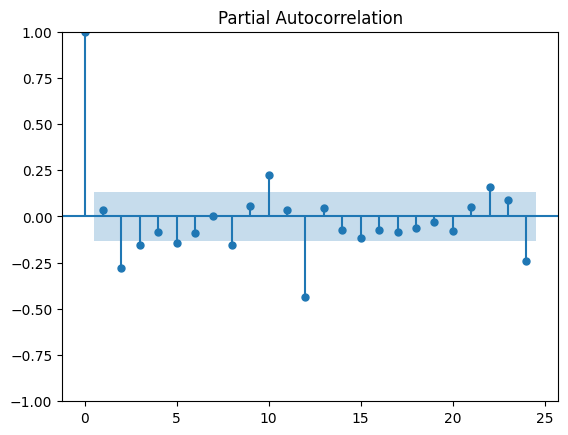

In [ ]:
d = is_stationarity(df)
print(d)

In [ ]:
model = ARIMA(df, order=(1, d, 2))
model_fit = model.fit() # обученная модель
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                   Цены   No. Observations:                  234
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -137.273
Date:                Sun, 04 Jun 2023   AIC                            282.545
Time:                        13:31:46   BIC                            296.350
Sample:                    01-01-2003   HQIC                           288.112
                         - 06-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5143      0.116      4.439      0.000       0.287       0.741
ma.L1         -0.7975      0.146     -5.463      0.000      -1.084      -0.511
ma.L2         -0.1742      0.133     -1.308      0.1

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


mae ARIMA:  0.2764833088987203
mape ARIMA:  0.0027629913564201475
rmse ARIMA:  0.33689306443802636
mse ARIMA::  0.11349693686644417


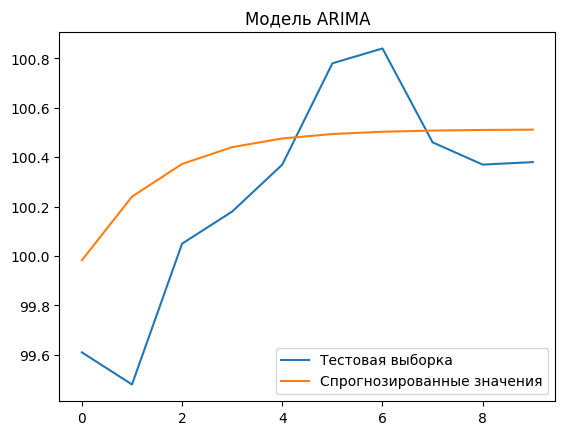

In [ ]:
forecast_test = model_fit.forecast(len(df_test))
fig, ax = plt.subplots()
ax.plot(df_test.values, label='Тестовая выборка')
ax.plot(forecast_test.values, label='Спрогнозированные значения')
ax.set_title('Модель ARIMA')
ax.legend()

print_metric(df_test, forecast_test)

In [ ]:
# p = range(0, 3)
# d = range(1,2)
# q = range(0, 3)
# pdq = list(itertools.product(p, d, q))
# seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
# print('Examples of parameter combinations for Seasonal ARIMA...')
# print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
# print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
# print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
# print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

# for param in pdq:
#     for param_seasonal in seasonal_pdq:
#         try:
#             mod = sm.tsa.statespace.SARIMAX(df,
#                                             order=param,
#                                             seasonal_order=param_seasonal,
#                                             enforce_stationarity=False,
#                                             enforce_invertibility=False)
#             results = mod.fit()
#             print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
#         except:
#             continue

In [ ]:
model = sm.tsa.statespace.SARIMAX(df, order=(1, 1, 2),
                                            seasonal_order=(1, 1, 2, 12),
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
model_fit = model.fit()
print(model_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                               Цены   No. Observations:                  234
Model:             SARIMAX(1, 1, 2)x(1, 1, 2, 12)   Log Likelihood                 -64.472
Date:                            Sun, 04 Jun 2023   AIC                            142.943
Time:                                    13:31:48   BIC                            165.818
Sample:                                01-01-2003   HQIC                           152.206
                                     - 06-01-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5959      0.107      5.580      0.000       0.387       0.805
ma.L1         -0.7421     81.426   

mae ARIMA:  0.16987442290004254
mape ARIMA:  0.0016946720418526784
rmse ARIMA:  0.17927955047982777
mse ARIMA::  0.032141157220249114


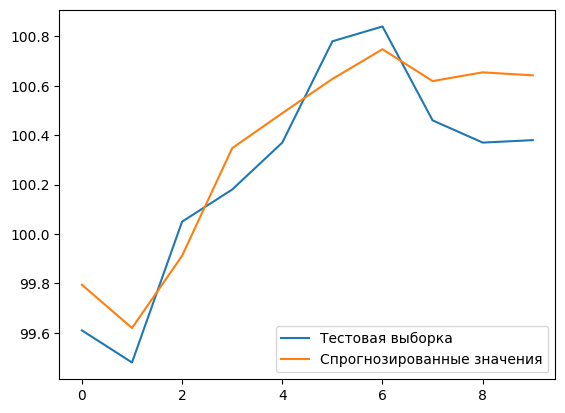

In [ ]:
forecast_test = model_fit.forecast(len(df_test) )#+ 20
fig, ax = plt.subplots()
ax.plot(df_test.values, label='Тестовая выборка')
ax.plot(forecast_test.values, label='Спрогнозированные значения')
ax.legend()

print_metric(df_test, forecast_test)

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


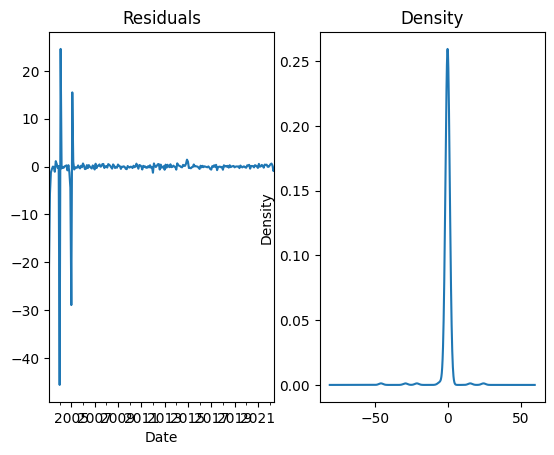

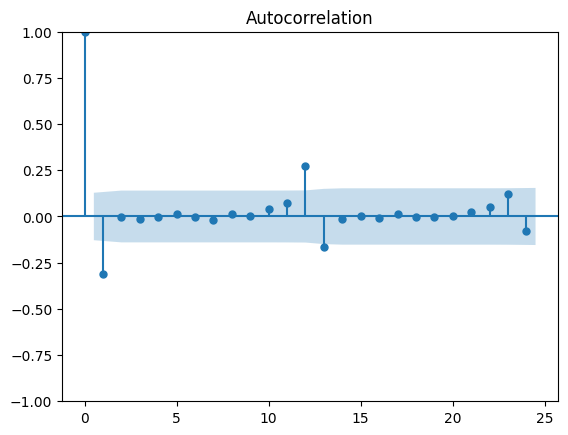

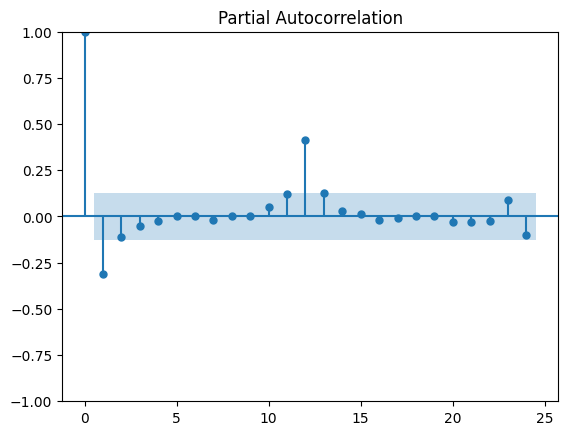

In [ ]:
import matplotlib.pyplot as plt
residuals = model_fit.resid[1:]
fig, ax = plt.subplots(1,2)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])

acf_res = plot_acf(residuals)

pacf_res = plot_pacf(residuals)
plt.show()

ValueError: ignored

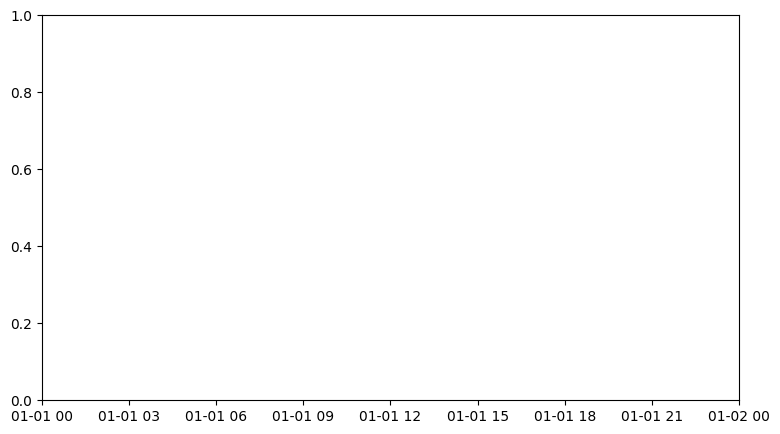

In [ ]:
dat = arr_date("2023-05-01", "2024-12-07")
dat = pd.to_datetime(dat, format='%m-%Y')

forecast_test['Date'] = dat

fig, ax = plt.subplots(figsize=(9, 5))
ax.plot(dat, forecast_test[:20].values, label='Спрогнозированные значения')
# ax.set_title('Прогноз на 2023 и 2024')
ax.legend()
